# PACKAGES AND LIBRARIES

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from warnings import filterwarnings
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, roc_curve
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization,MaxPooling2D
from keras import models
from keras import layers
import tensorflow as tf
import os
import os.path
from pathlib import Path
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from keras import regularizers
from keras.optimizers import RMSprop,Adam

ModuleNotFoundError: No module named 'cv2'

#### TRAIN

In [7]:
Train_Data_Path = Path("Training")

In [8]:
Train_JPG_Path = list(Train_Data_Path.glob(r"*/*.jpg"))

In [9]:
Train_JPG_Labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1],Train_JPG_Path))

In [10]:
print("NO: ",Train_JPG_Labels.count("no_tumor"))
print("Pituitary: ",Train_JPG_Labels.count("pituitary_tumor"))
print("Meningioma: ",Train_JPG_Labels.count("meningioma_tumor"))
print("Glioma: ",Train_JPG_Labels.count("glioma_tumor"))

NO:  395
Pituitary:  827
Meningioma:  822
Glioma:  826


In [11]:
Train_JPG_Path_Series = pd.Series(Train_JPG_Path,name="JPG").astype(str)
Train_JPG_Labels_Series = pd.Series(Train_JPG_Labels, name="TUMOR_CATEGORY")

In [12]:
Main_Train_Data = pd.concat([Train_JPG_Path_Series,Train_JPG_Labels_Series],axis=1)

#### TEST

In [13]:
Test_Data_Path = Path("Testing")

In [14]:
Test_JPG_Path = list(Test_Data_Path.glob(r"*/*.jpg"))

In [15]:
Test_JPG_Labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1],Test_JPG_Path))

In [16]:
print("NO: ",Test_JPG_Labels.count("no_tumor"))
print("Pituitary: ",Test_JPG_Labels.count("pituitary_tumor"))
print("Meningioma: ",Test_JPG_Labels.count("meningioma_tumor"))
print("Glioma: ",Test_JPG_Labels.count("glioma_tumor"))

NO:  105
Pituitary:  74
Meningioma:  115
Glioma:  100


In [17]:
Test_JPG_Path_Series = pd.Series(Test_JPG_Path,name="JPG").astype(str)
Test_JPG_Labels_Labels = pd.Series(Test_JPG_Labels,name="TUMOR_CATEGORY")

In [18]:
Main_Test_Data = pd.concat([Test_JPG_Path_Series,Test_JPG_Labels_Labels],axis=1)

# SHUFFLING

In [19]:
Main_Train_Data = Main_Train_Data.sample(frac=1).reset_index(drop=True)
Main_Test_Data = Main_Test_Data.sample(frac=1).reset_index(drop=True)

In [20]:
Main_Train_Data["TUMOR_CATEGORY"].replace({"glioma_tumor":"Glioma",
                                         "meningioma_tumor":"Meningioma",
                                         "no_tumor":"No",
                                         "pituitary_tumor":"Pituitary"},inplace=True)

In [21]:
Main_Test_Data["TUMOR_CATEGORY"].replace({"glioma_tumor":"Glioma",
                                         "meningioma_tumor":"Meningioma",
                                         "no_tumor":"No",
                                         "pituitary_tumor":"Pituitary"},inplace=True)

# VISUALIZATION

#### TRAIN

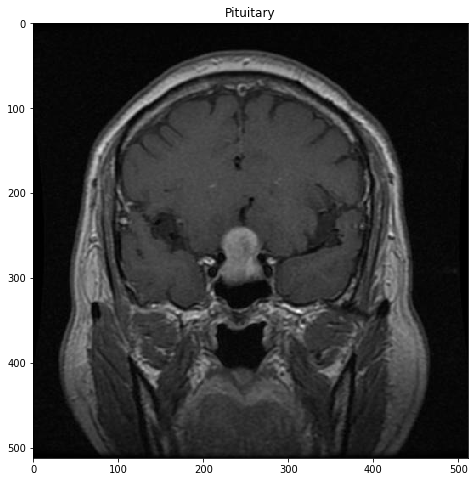

In [22]:
figure = plt.figure(figsize=(8,8))
plt.imshow(plt.imread(Main_Train_Data["JPG"][10],0))
plt.title(Main_Train_Data["TUMOR_CATEGORY"][10])
plt.show()

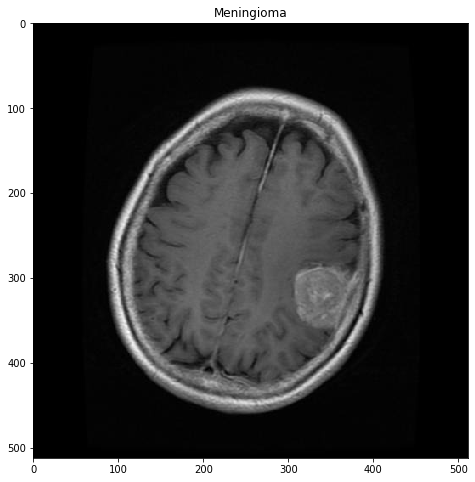

In [23]:
figure = plt.figure(figsize=(8,8))
plt.imshow(plt.imread(Main_Train_Data["JPG"][7],0))
plt.title(Main_Train_Data["TUMOR_CATEGORY"][7])
plt.show()

# MODEL TRAINING DATA

In [19]:
train_data,test_data = train_test_split(Main_Train_Data,train_size=0.9,random_state=42)

In [20]:
print(train_data.shape)

(2583, 2)


In [21]:
print(test_data.shape)

(287, 2)


# IMAGE GENERATOR

In [22]:
Generator = ImageDataGenerator(rescale=1./255,
                               brightness_range=[0.2,0.9],
                               featurewise_center=False,  
        samplewise_center=False, 
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range=0,
        zoom_range = 0,
        width_shift_range=0,  
        height_shift_range=0, validation_split=0.1)

In [23]:
Train_Set = Generator.flow_from_dataframe(dataframe=train_data,
                                         x_col="JPG",
                                         y_col="TUMOR_CATEGORY",
                                         seed=42,
                                          color_mode="rgb",
                                         class_mode="categorical",
                                          batch_size=10,
                                         subset="training"
                                         )

Found 2325 validated image filenames belonging to 4 classes.


In [24]:
print(Train_Set.class_indices)
print(Train_Set.classes[0:5])
print(Train_Set.image_shape)

{'Glioma': 0, 'Meningioma': 1, 'No': 2, 'Pituitary': 3}
[0, 1, 3, 3, 0]
(256, 256, 3)


In [25]:
Validation_Set = Generator.flow_from_dataframe(dataframe=train_data,
                                              x_col="JPG",
                                              y_col="TUMOR_CATEGORY",
                                              seed=42,
                                               color_mode="rgb",
                                              class_mode="categorical",
                                              batch_size=10,
                                               subset="validation"
                                              )

Found 258 validated image filenames belonging to 4 classes.


In [26]:
Test_Set = Generator.flow_from_dataframe(dataframe=test_data,
                                              x_col="JPG",
                                              y_col="TUMOR_CATEGORY",
                                              seed=42,
                                               color_mode="rgb",
                                              class_mode="categorical",
                                              batch_size=10
                                              )

Found 287 validated image filenames belonging to 4 classes.


# MODEL

In [27]:
Model = Sequential()
Model.add(Conv2D(filters = 64, kernel_size = (3,3), activation ='relu', input_shape = (256,256,3)))
Model.add(MaxPool2D(pool_size=(2,2)))
Model.add(Dropout(0.2))
Model.add(Conv2D(filters = 128, kernel_size = (3,3), activation ='relu'))
Model.add(MaxPool2D(pool_size=(2,2)))
Model.add(Dropout(0.2))
Model.add(Conv2D(filters = 128, kernel_size = (3,3), activation ='relu'))
Model.add(MaxPool2D(pool_size=(2,2)))
Model.add(Dropout(0.2))
Model.add(Conv2D(filters = 128, kernel_size = (3,3), activation ='relu'))
Model.add(MaxPool2D(pool_size=(2,2)))
Model.add(Dropout(0.2))
Model.add(Flatten())
Model.add(Dense(256, activation = "relu"))
Model.add(Dropout(0.25))
Model.add(Dense(4, activation = "softmax"))

In [28]:
Model.compile(optimizer=RMSprop(lr=0.001),
             loss="categorical_crossentropy",
             metrics=["accuracy"])

In [29]:
Call_Back = tf.keras.callbacks.EarlyStopping(monitor="loss",patience=2,mode="min")

In [30]:
CNN_Model = Model.fit(Train_Set,
                      validation_data=Validation_Set,
                     epochs=50,
                      batch_size=20,
                     callbacks=Call_Back)

Epoch 1/50
233/233 [==============================] - 35s 136ms/step - loss: 1.9466 - accuracy: 0.4360 - val_loss: 0.9104 - val_accuracy: 0.5853
Epoch 2/50
233/233 [==============================] - 17s 74ms/step - loss: 0.8009 - accuracy: 0.6679 - val_loss: 0.7264 - val_accuracy: 0.6512
Epoch 3/50
233/233 [==============================] - 17s 71ms/step - loss: 0.6654 - accuracy: 0.7281 - val_loss: 0.5462 - val_accuracy: 0.7791
Epoch 4/50
233/233 [==============================] - 17s 75ms/step - loss: 0.5342 - accuracy: 0.8109 - val_loss: 0.4518 - val_accuracy: 0.8217
Epoch 5/50
233/233 [==============================] - 17s 73ms/step - loss: 0.4348 - accuracy: 0.8424 - val_loss: 0.3538 - val_accuracy: 0.8798
Epoch 6/50
233/233 [==============================] - 17s 73ms/step - loss: 0.3877 - accuracy: 0.8572 - val_loss: 0.4454 - val_accuracy: 0.8527
Epoch 7/50
233/233 [==============================] - 17s 74ms/step - loss: 0.3119 - accuracy: 0.8767 - val_loss: 0.3368 - val_accuracy

In [31]:
Model_Results = Model.evaluate(Test_Set,verbose=False)
print("LOSS:  " + "%.4f" % Model_Results[0])
print("ACCURACY:  " + "%.2f" % Model_Results[1])

LOSS:  0.8301
ACCURACY:  0.91


In [32]:
print(Model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 64)      0         
_________________________________________________________________
dropout (Dropout)            (None, 127, 127, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 128)     73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 62, 62, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 128)       1

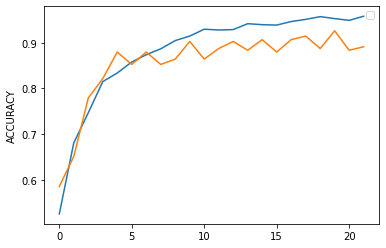

In [33]:
plt.plot(CNN_Model.history["accuracy"])
plt.plot(CNN_Model.history["val_accuracy"])
plt.ylabel("ACCURACY")
plt.legend()
plt.show()